# Shot Angles

We want to find what angle players are coming at the ball, so we can find out what angle they are shooting and whether or not their try to bounce the ball.

In [33]:
# Add this so we can import our haxml code from outside the notebooks folder.
import sys
sys.path.append("../")

from haxml.prediction import (
    generate_rows_demo
)
from haxml.utils import (
    load_match,
    inflate_match,
    get_stadiums,
    get_matches_metadata,
    to_clock,
    get_opposing_goalpost,
    stadium_distance,
    angle_from_goal,
    is_scored_goal
)
from haxml.viz import (
    plot_stadium,
    zoom_stadium,
    plot_positions
)
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import json
import pandas as pd

In [34]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")

In [35]:
meta_df = pd.DataFrame(metadata)
meta_df["scored_goals_total"] = meta_df["scored_goals_red"] + meta_df["scored_goals_blue"]
meta_df.sort_values(by="scored_goals_total", ascending=False).head()

,match_id,stadium,time,kicks_red,kicks_blue,score_red,score_blue,scored_goals_red,scored_goals_blue,scored_goals_total
843,-MQ56E0cq3qmgiUQG-8i,Futsal 3x3 4x4 from HaxMaps,599.9,156,192,9,6,7,5,12
902,-MQAc0o9-ypILrOePPYj,NAFL Official Map v1,476.6,151,114,10,1,10,1,11
903,-MQAet-H5t122ajmniD7,NAFL Official Map v1,619.2,192,187,10,4,6,2,8
139,-MPQHpvFPzKm5ZoPoCO7,NAFL Official Map v1,239.9,53,57,5,2,5,2,7
854,-MQ5OtBhTV-Xje300e5-,NAFL Official Map v1,626.9,172,145,4,3,4,3,7


In [36]:
def generate_rows_angles(match, stadium):
    """
    Generates target and features for each kick in the match.
    Produces two features for demo classifiers:
        goal_distance: Distance from where  ball was kicked to goal midpoint.
        goal_angle: Angle (in radians) between straight shot from where ball was
            kicked to goal midpoint.
    Args:
        match: Inflated match data (dict).
        stadium: Stadium data (dict).
    Returns:
        Generator of dicts with values for each kick in the given match.
        Includes prediction target "ag" (actual goals) which is 1 for a scored
        goal (goal or error) and 0 otherwise, "index" which is the index of the
        kick in the match kick list, and all the other features needed for
        prediction and explanation.
    """
    for i, kick in enumerate(match["kicks"]):
        gp = get_opposing_goalpost(stadium, kick["fromTeam"])
        x = kick["fromX"]
        y = kick["fromY"]
        gx = gp["mid"]["x"]
        gy = gp["mid"]["y"]
        dist = stadium_distance(x, y, gx, gy)
        angle = angle_from_goal(x, y, gx, gy)
        row = {
            "ag": 1 if is_scored_goal(kick) else 0,
            "index": i,
            "time": kick["time"],
            "x": x,
            "y": y,
            "from_name": kick["fromName"],
            "from_team": kick["fromTeam"],
            "goal_x": gx,
            "goal_y": gy,
            "goal_distance": dist,
            "goal_angle": angle,
            "team": kick["fromTeam"],
            "stadium": match["stadium"]
        }
        yield row

In [190]:
#1800 (weirddd)
#1097 2 work and one doesnt
#Going 2 indeces down works so much detter with this match 222
#Match 420 has the first goal as a bit off and the other 3 as accurate (first goals least dist is 105?)
meta = metadata[1097]
meta

{'match_id': '-MQTJKtlHd2yXiof1R8_',
 'stadium': 'NAFL Official Map v1',
 'time': 178.2,
 'kicks_red': 51,
 'kicks_blue': 45,
 'score_red': 1,
 'score_blue': 2,
 'scored_goals_red': 1,
 'scored_goals_blue': 2}

In [191]:
key = meta["match_id"]
infile = "../data/packed_matches/{}.json".format(key)
stadium = stadiums[meta["stadium"]]
match = load_match(infile)
row_gen = generate_rows_angles(match, stadium)
df = pd.DataFrame(row_gen)
df["match"] = key

In [192]:
df.head()

,ag,index,time,x,y,from_name,from_team,goal_x,goal_y,goal_distance,goal_angle,team,stadium,match
0,0,0,1.5,0.0,10.0,Player 616,red,700,0,700.071425,1.556512,red,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_
1,0,1,4.2,55.0,-264.0,Player 359,red,700,0,696.936869,1.182297,red,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_
2,0,2,5.0,361.0,-42.0,Player 343,blue,-700,0,1061.830966,1.531232,blue,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_
3,0,3,6.3,44.0,-146.0,Player 359,red,700,0,672.050593,1.351805,red,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_
4,0,4,8.4,240.0,-109.0,Player 343,blue,-700,0,946.298579,1.455354,blue,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_


In [193]:
pd.DataFrame(match["positions"]).head(20)

,type,time,x,y,playerId,name,team
0,player,0.0,200.0,0.0,24.0,Player 117,blue
1,player,0.0,200.0,55.0,28.0,Player 343,blue
2,player,0.0,200.0,-55.0,33.0,Player 621,blue
3,player,0.0,200.0,110.0,41.0,Player 623,blue
4,player,0.0,-200.0,0.0,43.0,Player 359,red
5,player,0.0,-200.0,55.0,40.0,Player 320,red
6,player,0.0,-200.0,-55.0,34.0,Player 616,red
7,player,0.0,-200.0,110.0,44.0,Player 624,red
8,ball,0.0,0.0,0.0,NaN,None,None
9,player,0.3,257.0,-49.0,24.0,Player 117,blue


In [194]:
example = df.query("ag == 1").to_dict(orient="records")[0]
example

{'ag': 1,
 'index': 27,
 'time': 49.5,
 'x': -342.0,
 'y': 224.0,
 'from_name': 'Player 117',
 'from_team': 'blue',
 'goal_x': -700,
 'goal_y': 0,
 'goal_distance': 422.30320860727545,
 'goal_angle': 1.0116950034613763,
 'team': 'blue',
 'stadium': 'NAFL Official Map v1',
 'match': '-MQTJKtlHd2yXiof1R8_'}

In [195]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



In [196]:
def get_positions_at_time(positions, t):
    """
    Return a list of positions (dicts) closest to, but before time t.
    """
    # Assume positions list is already sorted.
    # frame is a list of positions (dicts) that have the same timestamp.
    frame = []
    frame_time = 0.0
    for pos in positions:
        # If we passed the target time t, return the frame we have
        if pos["time"] > t:
            break
        # If this positions is part of the current frame, add it
        if pos["time"] == frame_time:
            frame.append(pos)
        # If the current frame is over, make a new frame and add this position to it
        else:
            frame = []
            frame.append(pos)
            frame_time = pos["time"]
    return frame

In [197]:
def get_positions_in_range(positions, start, end):
    """
    Return a list of positions (dicts) between start and end (inclusive).
    """
    assert start <= end, "Time `start` must be before `end`."
    
    def is_in_time_range(pos):
        return pos["time"] >= start and pos["time"] <= end
    
    return list(filter(is_in_time_range, positions))

In [198]:
offset = 2 # seconds
print("Get positions at {}.".format(example["time"] - offset))
r1 = get_positions_at_time(match["positions"], example["time"])
pd.DataFrame(r1)

Get positions at 47.5.


,type,time,x,y,playerId,name,team
0,player,49.3,-324.0,157.0,24.0,Player 117,blue
1,player,49.3,-417.0,-288.0,28.0,Player 343,blue
2,player,49.3,-112.0,-37.0,33.0,Player 621,blue
3,player,49.3,-737.0,100.0,41.0,Player 623,blue
4,player,49.3,-491.0,133.0,43.0,Player 359,red
5,player,49.3,-607.0,-20.0,40.0,Player 320,red
6,player,49.3,-195.0,113.0,34.0,Player 616,red
7,player,49.3,-320.0,210.0,44.0,Player 624,red
8,ball,49.3,-672.0,-27.0,NaN,None,None


In [199]:
print("Get positions between {} and {}.".format(example["time"] - offset, example["time"]))
r2 = get_positions_in_range(match["positions"], example["time"] - offset, example["time"])
pd.DataFrame(r2)

Get positions between 47.5 and 49.5.


,type,time,x,y,playerId,name,team
0,player,47.7,-334.0,249.0,24.0,Player 117,blue
1,player,47.7,-379.0,-231.0,28.0,Player 343,blue
2,player,47.7,-20.0,105.0,33.0,Player 621,blue
3,player,47.7,-634.0,272.0,41.0,Player 623,blue
4,player,47.7,-571.0,244.0,43.0,Player 359,red
...,...,...,...,...,...,...,...
58,player,49.3,-491.0,133.0,43.0,Player 359,red
59,player,49.3,-607.0,-20.0,40.0,Player 320,red
60,player,49.3,-195.0,113.0,34.0,Player 616,red
61,player,49.3,-320.0,210.0,44.0,Player 624,red


In [200]:
help(plot_positions)

Help on function plot_positions in module haxml.viz:

plot_positions(positions, stadium)
    Draws a list of positions on the stadium.
    Args:
        positions: List of positions (dicts) to draw.
        stadium: Stadium data (dict).
    Returns:
        Tuple (fig, ax).



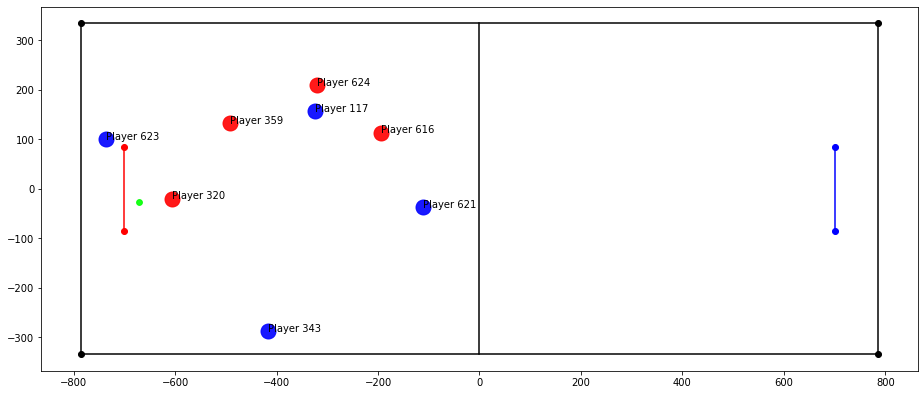

In [201]:
fig, ax = plot_positions(r1, stadium)
fig.set_size_inches(*zoom_stadium(stadium["bounds"]))
for pos in r1:
    ax.text(pos["x"], pos["y"], pos["name"])
fig

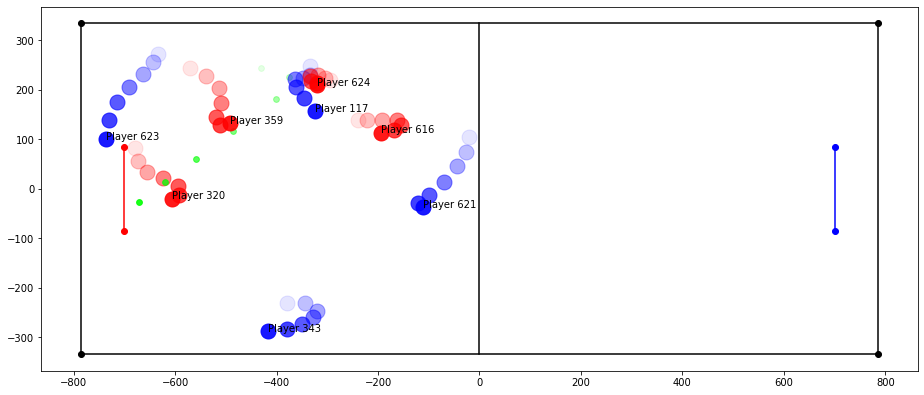

In [202]:
fig, ax = plot_positions(r2, stadium)
fig.set_size_inches(*zoom_stadium(stadium["bounds"]))
# Most recent position for each player
# Key: Name, Value: position (dict)
last_pos = {}
for pos in r2:
    last_pos[pos["name"]] = pos
for pos in last_pos.values():
    ax.text(pos["x"], pos["y"], pos["name"])
fig

In [203]:
df.query("ag == 1")

,ag,index,time,x,y,from_name,from_team,goal_x,goal_y,goal_distance,goal_angle,team,stadium,match
27,1,27,49.5,-342.0,224.0,Player 117,blue,-700,0,422.303209,1.011695,blue,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_
34,1,34,64.9,101.0,108.0,Player 624,red,700,0,608.658361,1.392412,red,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_
91,1,91,169.4,-486.0,-53.0,Player 117,blue,-700,0,220.465417,1.328018,blue,NAFL Official Map v1,-MQTJKtlHd2yXiof1R8_


In [204]:
bounce = df.query("ag == 1").to_dict(orient="records")[1]
bounce

{'ag': 1,
 'index': 34,
 'time': 64.9,
 'x': 101.0,
 'y': 108.0,
 'from_name': 'Player 624',
 'from_team': 'red',
 'goal_x': 700,
 'goal_y': 0,
 'goal_distance': 608.6583606589168,
 'goal_angle': 1.3924123336595577,
 'team': 'red',
 'stadium': 'NAFL Official Map v1',
 'match': '-MQTJKtlHd2yXiof1R8_'}

Start: 1:00
End  : 1:04


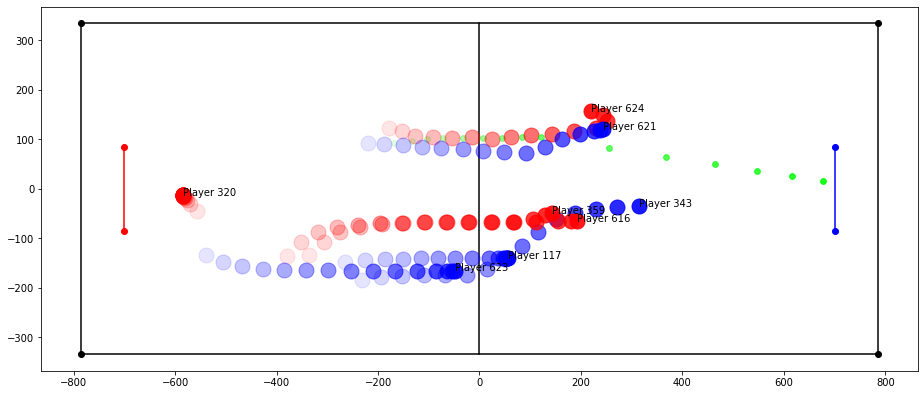

In [205]:
end_time = bounce["time"] - 0.1
start_time = end_time - 4
print(f"Start: {to_clock(start_time)}")
print(f"End  : {to_clock(end_time)}")
time_range = get_positions_in_range(match["positions"], start_time, end_time)
fig, ax = plot_positions(time_range, stadium)
fig.set_size_inches(*zoom_stadium(stadium["bounds"]))
# Most recent position for each player
# Key: Name, Value: position (dict)
last_pos = {}
for pos in time_range:
    last_pos[pos["name"]] = pos
for pos in last_pos.values():
    ax.text(pos["x"], pos["y"], pos["name"])
fig

Note: Vinesh needs to fix the plotting methods, because they are mirror-images vertically, but this shouldn't be a big deal for now.

Notes for computing player/ball angle:
- Players can pivot really quickly, so the angle is very sensitive, small changes can have big effects
- We want to get the angle between player and ball in the last frame before they kick the ball
- We want to compare the angle between the player and the ball to the goal
- If we draw a ray from the position of the player through the position of the ball, that tells us the shot course
- If the shot course is going into the goal, it's a direct shot
- If the shot course is going away from the goal, they may be trying to bounce it in
- Where does the shot course intersect with the goal line?
- The goal line is a vertical line at the X-coordinate of the goal
- If the intersection is between the posts, it's shooting at the goal, otherwise, away from the goal
- If the intersection point is outside the field, they are bouncing off the sidelines
- We don't know where the sideline is exactly
- You can pick a certain distance that if the intersection is far from the posts, it was a sideline bounce
- Keep in mind, stadiums have different sizes! Try to use relative sizes
- The get positions by time range returns a list of dicts
- But you could write one that returns a list of lists of dicts, where each sub-list is a single frame

Pseudocode for computing player/ball angle:
- Find the last frame before the player kicks the ball
    - Pick a time range, get the positions
    - For each frame (positions grouped by time), calculate distance between kicker and ball
    - Search backwards, from the last frame, and once the distance stops decreasing, pick that frame
- Compute the shot course and intersection
- Use the shot course and intersection to make some features!

In [206]:
# We can get the X-coordinate of the goal like this:
# If your team is red, then you should be shooting at the blue goal
gp_blue = get_opposing_goalpost(stadium, "red")
# We can just use the coordinates of the midpoint:
print(gp_blue["mid"])
# After we get an intersection point, we want to know if it is between the posts
print(gp_blue["posts"])

{'x': 700, 'y': 0}
[{'x': 700, 'y': -85}, {'x': 700, 'y': 85}]


In [207]:
# We can get the bounds of the field:
print(stadium["bounds"])

{'minX': -785, 'maxX': 785, 'minY': -335, 'maxY': 335}


In [208]:
""" my brainstorming lol"""

' my brainstorming lol'

Planning on making these functions:
1) player_ball_angle-- gets the angle of the shot (by finding the angle of player to ball) 

2) shot_intersection -- gets where the shot is going to intersect (takes in the shot_course and type of field)

3) shot_to_goal -- gives back a corrrelation number between 0 to 1 (1 being that the shot angle is the exact same as the ball/goal and 0 being the opposite direction) (higher the number, more XG awarded)

4) post_award -- if the shot_intersection is on the post, award 0.5 

pre-existing functions to utilize:

Getting the angle between player and ball:

    get_positions_in_range()
    get_positions_at_time()
   
Compute the shot intersection:

    player_ball_angle 
    stadium (get bounds, mid, and size)
    get_opposing_goalpost()

In [209]:
def player_ball_angle(x,y,bx,by):
    '''Finds the expected angle of the shot (Using midpoints)
   Args:
       x: x position of player
       y: y position of player
       bx: x position  ball
       by: y position of ball
    Returns:
       Int that represents the angle of the shot (which is the angle of the player to the ball)
    '''
    # abs of x distance and y distnace between ball and player
    dx = float(abs(x - gx))
    dy = float(abs(y - gy))
    # Avoid division by zero error.
    angle = math.atan(dx / dy) if dy > 0 else math.pi / 2.0
    return angle


In [225]:
def shot_intersection(match,kick, stadium, offset):
    '''Finds where the ball would intersect
    Args:
    match: Which match it is
    kick: Which kick we want to measure
    staduim: What stadium size it is (so we know where the goals and bounds are)

    Returns:
    Int 1 or 0 if the ball is going towars the goal or not
    '''
    #Getting last frame before the kick 
    print("Calculate intersection at time: {}".format(kick["time"] - offset))
    #frame = get_positions_at_time(match["positions"], kick["time"] - offset)
    #Using in range and tracing back to see what frame was right before it left the foot
    frame = get_positions_in_range(match["positions"], kick["time"] - offset,kick["time"])
    #A list of lists with only info about player we want and ball
    shooter_frames = []
    ball_frames = []
    print(kick['from_name'])
    for i in frame:
        if i['name'] == kick['from_name']:
            shooter_frames.append(i)  
        elif i['type'] == 'ball':
            ball_frames.append(i)
    print((shooter_frames))
    print((ball_frames))
    #print(shooter_frames)
    #print(ball_frames)
    #picking frame with least dist
    least_dist = float(math.inf)
    btwn_dist = {'upper': 1, 'lower':1}
    player_position = {}
    ball_position = {}
    length = min(len(shooter_frames),len(ball_frames))
    set_dist = 30 #ball and player are at least get within 30 units then we assume that it was kicked
    for i in range(length-1,-1,-1): #frame len of ball and shooter should be the same
        dist = stadium_distance(shooter_frames[i]['x'],shooter_frames[i]['y'],ball_frames[i]['x'],ball_frames[i]['y'])
        print(dist)
        if dist <= set_dist:
            player_position = shooter_frames[i]
            ball_position = ball_frames[i]
            break
    if not bool(ball_position) or not bool(player_position): #The dictionaries were not populated yet so default to getting least distance
        print("using least diff")
        for i in range(length-1,-1,-1): #frame len of ball and shooter should be the same
            dist = stadium_distance(shooter_frames[i]['x'],shooter_frames[i]['y'],ball_frames[i]['x'],ball_frames[i]['y'])
            print(dist)
            if dist <= least_dist:
                player_position = shooter_frames[i]
                ball_position = ball_frames[i]
                least_dist = dist
            else: #stopped decreasing
                print(shooter_frames[i]['time'])
                print("breaking")
                break
    #print("least distance is" + str(least_dist))
    last = len(shooter_frames)-1
    print("last frame is "+ str(stadium_distance(shooter_frames[0]['x'],shooter_frames[0]['y'],ball_frames[0]['x'],ball_frames[0]['y'])))
    #print(frame)
    print(player_position)
    print(ball_position)
    #Getting goal positions
    goal_mid = get_opposing_goalpost(stadium, kick['team'])['mid']
    #print(goal_mid)
     #Extend line from shot angle (can't extend lines easily)
    y_val = point_slope(
        player_position,
        slope(player_position['x'], player_position['y'], ball_position['x'], ball_position['y']),
        goal_mid['x']
    )
    #Checking if the projection between the posts
    intersect = { 'x': goal_mid['x'], 'y': y_val }
    return player_position, ball_position, intersect


In [226]:
def point_slope(p, slope,x_goal):
    #y - y1 = m(x-x1) -->  y=mx-mx1+y1 (returning the y)
    y_val = (slope*x_goal)-(slope*p['x'])+p['y'] 
    return y_val

In [227]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m

In [228]:
example = df.query("ag == 1").to_dict(orient="records")[0]
example

{'ag': 1,
 'index': 27,
 'time': 49.5,
 'x': -342.0,
 'y': 224.0,
 'from_name': 'Player 117',
 'from_team': 'blue',
 'goal_x': -700,
 'goal_y': 0,
 'goal_distance': 422.30320860727545,
 'goal_angle': 1.0116950034613763,
 'team': 'blue',
 'stadium': 'NAFL Official Map v1',
 'match': '-MQTJKtlHd2yXiof1R8_'}

Start: 47.5
End  : 49.5
Calculate intersection at time: 48.5
Player 117
[{'type': 'player', 'time': 48.5, 'x': -364.0, 'y': 222.0, 'playerId': 24, 'name': 'Player 117', 'team': 'blue'}, {'type': 'player', 'time': 48.8, 'x': -361.0, 'y': 206.0, 'playerId': 24, 'name': 'Player 117', 'team': 'blue'}, {'type': 'player', 'time': 49.0, 'x': -346.0, 'y': 183.0, 'playerId': 24, 'name': 'Player 117', 'team': 'blue'}, {'type': 'player', 'time': 49.3, 'x': -324.0, 'y': 157.0, 'playerId': 24, 'name': 'Player 117', 'team': 'blue'}]
[{'type': 'ball', 'time': 48.5, 'x': -486.0, 'y': 117.0, 'playerId': None, 'name': None, 'team': None}, {'type': 'ball', 'time': 48.8, 'x': -559.0, 'y': 61.0, 'playerId': None, 'name': None, 'team': None}, {'type': 'ball', 'time': 49.0, 'x': -620.0, 'y': 13.0, 'playerId': None, 'name': None, 'team': None}, {'type': 'ball', 'time': 49.3, 'x': -672.0, 'y': -27.0, 'playerId': None, 'name': None, 'team': None}]
393.6495903719449
322.45309736456244
245.41597340026587
160.9627

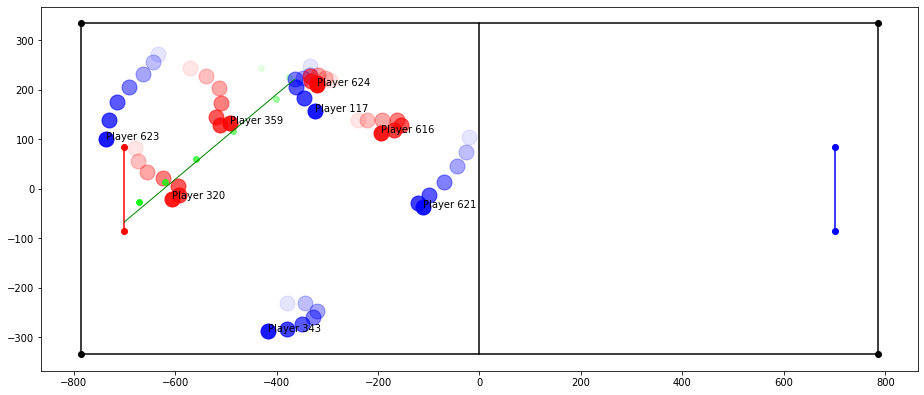

In [229]:
end_time = example["time"]
start_time = end_time - 2
print(f"Start: {start_time}")
print(f"End  : {end_time}")
time_range = get_positions_in_range(match["positions"], start_time, end_time)
player_pos, ball_pos, intersect = shot_intersection(match,example,stadium, offset=1)
print(intersect)
fig, ax = plot_positions(time_range, stadium)
fig.set_size_inches(*zoom_stadium(stadium["bounds"]))
on_goal = shot_on_goal(match, example, intersect, stadium)
print("on_goal feature " + str(on_goal))
# Most recent position for each player
# Key: Name, Value: position (dict)
last_pos = {}
for pos in time_range:
    last_pos[pos["name"]] = pos
for pos in last_pos.values():
    ax.text(pos["x"], pos["y"], pos["name"])
ax.plot(
    [player_pos['x'], ball_pos['x'], intersect['x']],
    [player_pos['y'], ball_pos['y'], intersect['y']],
    color="green", linewidth=1
)
fig

In [230]:
import math

def dist_formula(x1,y1,x2,y2):
    dist = math.sqrt( ((x1-x2)**2)+((y1-y2)**2) )
    return dist

In [221]:
def speed_player(match,kick,player_name, offset):
    '''' Speed of the player
       Args:
           match: Which match it is
           kick: Which kick we want to measure
           player_name: What player do we want to measure the speed for

        Returns:
           Int that represents the speed of the player
    '''
    #Getting time range to be able to measure distance
    #start = get_positions_at_time(match["positions"], kick["time"] - offset)
    #end = get_positions_at_time(match["positions"], kick["time"])
    #getting positions
    positions = get_positions_in_range(match["positions"], kick["time"] - offset,kick["time"])
    #print(positions)
    player_pos = []
    #A list of lists with only info about player we want
    for i in positions:
        if i['name'] == player_name: #5th column in df is the id field
            player_pos.append(i)    
    #print(player_pos)
    #Getting the time
    if len(player_pos) > 0:
        last = len(player_pos)-1#getting last index)
        time = player_pos[last]['time'] -  player_pos[0]['time'] 
        #Getting the distance 
        distance = stadium_distance(player_pos[0]['x'],player_pos[0]['y'],player_pos[last]['x'],player_pos[last]['y'])
        #dist_formula(player_pos[0]['x'],player_pos[0]['y'],player_pos[last]['x'],player_pos[last]['y'])
        print("dist:" + str(distance))
        print("time:" + str(time))
        #Returns speed
        #NEED TO CHANGE TIME INTO SECONDS SO THAT IT IS CONSTANT AND NOT DIVIDING BY DIFF VALS
        return distance/time
    else:
        return 0

In [167]:
name = 'Player 52'
print(speed_player(match,example, name, offset=9))

0


In [168]:
def defender_feature_weighted(match,kick,stadium,dist):
    '''Figuring out the closest defender and num of defenders for a kick
        Note: This is weighted so that defenders that are close to the player/ball or the goal count as 1.5 rather than 1
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            dist: Set distance to consider a player pressuring

        Returns:
                List that contains the distance of the closest defender and the number of defenders (weighted)
'''
    positions = get_positions_at_time(match["positions"], kick["time"])
    closest_defender = float('inf')
    defenders_pressuring = 0
    ret = [0,0]
    for person in positions:
        if person['team'] is not kick['fromTeam'] and person['type'] == "player": 
            defender_dist = stadium_distance(kick['fromX'],kick['fromY'],person['x'],person['y'])
            #((kick['fromX'] - person['x'])**2 + (kick['fromY'] - person['y'])**2)**(1/2)
            if defender_dist < closest_defender:
                closest_defender = defender_dist
                ret[0] = closest_defender
            if defender_dist <= dist:
                #Checking distances  for weights
                #Not sure what to call "close" to player or goal (currently doing 5)
                post = get_opposing_goalpost(stadium, "red")
                goal_dist = stadium_distance(post['mid'][0], post['mid'][1] ,person['x'],person['y'])
                if defender_dist <= 5:
                    defenders_pressuring += 1.5
                elif goal_dist <= 5:
                    defenders_pressuring += 1.5
                else:
                    defenders_pressuring += 1
                ret[1] = defenders_pressuring
    return ret

In [169]:
#Testing!!

# Features

Some ideas:

    Boolean (1 or 0) depending on if shot should intersect goal w/ clear shot
    
    Is player in the way: Go through all player positions and check if it hits any point on the intersection line (by checking = points or within the range based on the raduis of player (Return 1 or 0 if player is in the way of the shot)
    
    Using speed of player and speed of ball, check if it it can go the distance to get to the goal
    
    

In [170]:
def shot_on_goal(match, kick, intersect, stadium):
    '''Figuring out if shot is going into the goal or not
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            intersect: x,y of the shot intersection
            stadium: Which staduim was it played on

        Returns:
                1 if shot is on goal, .5 if it hits the post, and 0 if it isn't on goal
    '''
    goal_posts = get_opposing_goalpost(stadium, kick['team'])['posts']
    if intersect['y'] > goal_posts[0]['y'] and intersect['y'] < goal_posts[1]['y']:
        return 1
    elif intersect['y'] == goal_posts[0]['y'] or intersect['y'] == goal_posts[1]['y']:
        #hits posts
        return .5
    else:
        return 0

In [171]:
print(shot_on_goal(match, example, intersect, stadium))

0


In [172]:
def blocking_players(match, kick, intersect, ball_pos, stadium):
    '''Find if there is a player blocking the shot
        Args:
            match: Which match it is
            kick: Which kick we want to measure
            intersect: x,y of the shot intersection
            ball_pos: Point for the balls position
            stadium: Which staduim was it played on

        Returns:
                1 if shot is on goal, .5 if it hits the post, and 0 if it isn't on goal
    '''
    #How will we account for raduis? --> one case is if the center of a player is on a point on the line but what if it isnt the center
    #Get position of all players at the frame we get the intersection from and then check all of their positions -- how will we know the frame

In [173]:
#line - ax + by = c --> how to get the a,b,c constants
#point-slope form to linear equation 
#y - y1 = m(x-x1) -->  ax + by = c
#Tricky -- a can't be a fraction
def check_collision(a, b, c, x, y, radius): 
    '''Checking if shot line intersection is colliding with a player
        Args:
                a,b,c = constants
                x: x position of the center of the player
                y: y position of the center of the player
                raduis: Radius of the player

            Returns:
                    1 if shot is on goal, .5 if it hits the post, and 0 if it isn't on goal
    '''
      
    # Find dist of line from center of circle
    dist = ((abs(a * x + b * y + c)) /
            math.sqrt(a * a + b * b)) 
    # Checking if the distance is less  
    # than, greater than or equal to radius. 
    if radius == dist or radius > dist: 
        print("colliding")
    else: 
        print("Not colliding")

a = 0.0833333333333332
b = 231.66666666666677


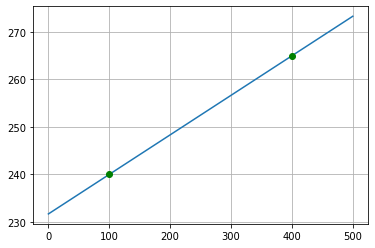

In [174]:
import numpy as np
import matplotlib.pyplot as plt

# Define the known points
x = [100, 400]
y = [240, 265]

# Calculate the coefficients. This line answers the initial question. 
coefficients = np.polyfit(x, y, 1)

# Print the findings
print ('a =', coefficients[0])
print ('b =', coefficients[1])

# Let's compute the values of the line...
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(0,500,100)
y_axis = polynomial(x_axis)

# ...and plot the points and the line
plt.plot(x_axis, y_axis)
plt.plot( x[0], y[0], 'go' )
plt.plot( x[1], y[1], 'go' )
plt.grid('on')
plt.show()